# INPUT SECTION

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rain_evap=np.loadtxt(r"C:\Users\Luis\BENCHMARK TESTS\Flow boundary conditions\data\infiltration.dat",skiprows=1,delimiter=',',usecols=1)
num_values = rain_evap.size
num_values

3653

In [16]:
# INPUT DATA
def setpars():
    pars={}
    pars['thetaR']=0.131
    pars['thetaS']=0.396
    pars['alpha']=0.423
    pars['n']=2.06
    pars['m']=1-1/pars['n']
    pars['Ks']=0.0496
    pars['Ss']=0.000001
    return pars

pars=setpars()

qT=rain_evap/1000*-1
t=np.arange(len(qT))
dt=t[1]-t[0]
nt=len(t)

# Spatial grid:
dz=0.05
zN=1.5
z=np.arange(dz/2,zN,dz)
n=len(z)

# Initialize array:
psi=np.zeros((nt,n))

# ICs:
psi[0,:]=-3.59

# MODEL SET UP

In [17]:
# DEPENDENT VARIABLES CALCULATION
def Cfun(psi,pars):
    x3=1+(pars['alpha']*np.abs(psi))**pars['n']
    x2=x3**(pars['m']+1)
    x1=pars['alpha']*pars['n']*pars['m']*((pars['alpha']*np.abs(psi))**(pars['n']-1))/x2
    C = np.where(psi >= 0, pars['Ss'], (pars['thetaS']-pars['thetaR'])*x1)
    return C

def Kfun(psi,pars):
    x6=1+(pars['alpha']*np.abs(psi))**pars['n']
    x5=x6**(pars['m']*0.5)
    x4=((pars['alpha']*np.abs(psi))**(pars['n']-1))*(x6**(-pars['m']))
    x3=1-x4
    x2=x3**2.
    x1=x2/x5
    K = np.where(psi >= 0, pars['Ks'], pars['Ks']*x1)
    return K

def thetafun(psi,pars):
    x3=1+(pars['alpha']*np.abs(psi))**pars['n']
    x2=x3**pars['m']
    x1=(pars['thetaS']-pars['thetaR'])/x2
    theta = np.where(psi >= 0, pars['thetaS'], pars['thetaR']+x1)
    return theta

def solverfun(R,C,Kmid,dt,dz,n):
    # Initialize arrays
    a=np.zeros(n)
    b=np.zeros(n)
    c=np.zeros(n)
    y=np.zeros(n)

    # Construct matrix
    a=-Kmid[:-1]/dz
    b=(Kmid[:-1]+Kmid[1:])/dz+C*dz/dt
    c=-Kmid[1:]/dz

    # Lower boundary:
    b[0]=Kmid[1]/dz+C[0]*dz/dt

    # Upper boundary:
    b[-1]=Kmid[-2]/dz+C[-1]*dz/dt

    A=np.diag(a[1:],-1)+np.diag(b,0)+np.diag(c[:-1],1)

    # Construct RHS
    y[:]=R[:]

    # Boundary conditions - nothing to do
    #y[0]=y[0]
    #y[-1]=y[-1]

    # Solve:
    dell = np.linalg.solve(A, y)

    return dell

def Rfun(psiiter,psiin,qT,KB,C,Kmid,dtheta,dt,dz,n):
    # This solves the Picard residual term:
    zero=np.array([0.])
    psigrid=np.hstack((zero,psiiter,zero))

    x1=-dtheta/dt*dz
    x2=(Kmid[1:]-Kmid[:-1])
    x3=Kmid[1:]*(psigrid[2:]-psigrid[1:-1])/dz
    x4=-Kmid[:-1]*(psigrid[1:-1]-psigrid[:-2])/dz

    # Lower boundary:
    x2[0]=Kmid[1]
    x4[0]=-KB

    # Upper boundary:
    x2[-1]=-Kmid[-2]
    x3[-1]=-qT

    R=x1+x2+x3+x4

    return R

def iterfun(psiin,pars,qT,dt,dz,n):
    # psiin = psi^n
    # psiiter = psi^n+1,m
    # psiout = psi^n+1,m+1

    tolerance=1e-10
    maxcount=10000
    zero=np.array([0.])
    
    # Initialize arrays
    psiiter=np.zeros(len(psiin))
    psiout=np.zeros(len(psiin))

    # Initial guess: psi_n+1^1 = psi_n
    psiiter[:]=psiin[:]

    count=0
    while count <= maxcount:
        # Get C,K:
        C=Cfun(psiiter,pars)
        K=Kfun(np.hstack((zero, psiiter, zero)),pars)
        Kmid=(K[1:]+K[:-1])/2
        dtheta=thetafun(psiiter,pars)-thetafun(psiin,pars)
        # Get R
        R=Rfun(psiiter,psiin,qT,K[1],C,Kmid,dtheta,dt,dz,n)
        # Solve for del
        dell=solverfun(R,C,Kmid,dt,dz,n)
        # Update psi estimates at different iteration levels
        psiout[:]=psiiter[:]+dell[:]
        
        psiiter[:]=psiout[:]
        
        # Check for convergence
        if np.max(np.abs(R)) < tolerance:
            break
        
        count+=1
        
    return psiout

def massbal(psi,qT,pars,n,dt,dz):

    # Initial storage:
    theta=thetafun(psi.reshape(-1),pars)
    theta=np.reshape(theta,psi.shape)
    S=np.sum(theta*dz,1)
    S0=S[0]
    SN=S[-1]

    # Inflow:
    Kin=Kfun(psi[:,0],pars)
    QIN=-Kin
    QIN[0]=0.
    QINsum=np.sum(QIN)*dt

    # Outflow:
    QOUT=qT
    QOUT[0]=0.
    QOUTsum=np.sum(QOUT)*dt

    # Balance:
    dS=SN-S0
    dQ=QINsum-QOUTsum
    err=dS/dQ

    return QIN,QOUT,S,err

def ModelRun(dt,dz,n,nt,psi,qT,pars):
    # Solve:
    for j in range(1,nt):
        psi[j,:]=iterfun(psi[j-1,:],pars,qT[j],dt,dz,n)

    QIN,QOUT,S,err=massbal(psi,qT,pars,n,dt,dz)

    return psi,QIN,QOUT,S,err

# SIMULATION RUN

In [18]:
psi,QIN,QOUT,S,err=ModelRun(dt,dz,n,nt,psi,qT,pars)
err, psi

(1.0000002726638502,
 array([[-3.59      , -3.59      , -3.59      , ..., -3.59      ,
         -3.59      , -3.59      ],
        [-3.59018077, -3.59019377, -3.59022006, ..., -3.6822663 ,
         -3.710112  , -3.74718677],
        [-3.59096935, -3.59102607, -3.59113993, ..., -3.75908513,
         -3.79457413, -3.83686614],
        ...,
        [-3.40108543, -3.40188175, -3.40343139, ..., -3.42242471,
         -3.43104641, -3.4554525 ],
        [-3.41155487, -3.41222158, -3.41351498, ..., -3.5383519 ,
         -3.5674837 , -3.60620994],
        [-3.41995749, -3.42049554, -3.42153763, ..., -3.44706644,
         -3.43250632, -3.4104873 ]]))

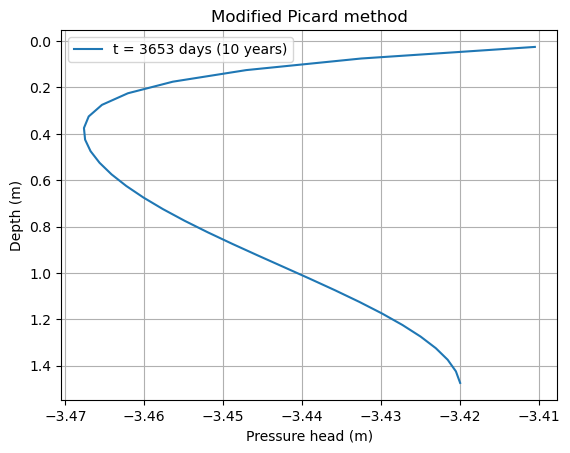

In [19]:
# Plotting psi at the last time step
z_depth = np.flip(z)
psi_plot = plt.plot(psi[3652], z_depth, label='t = 3653 days (10 years)') # Plot z vs psi for each dti
plt.xlabel('Pressure head (m)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()
plt.title('Modified Picard method')
plt.legend()  # Show legend with dti values
plt.grid(True)
plt.show()

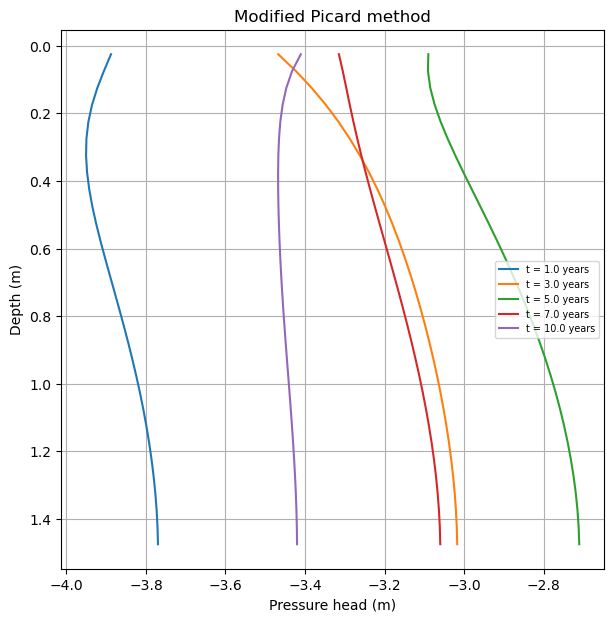

In [20]:
# Specify the time steps you want to plot
time_steps = [366, 1098, 1826, 2921, 3652]  # Adjusted for zero-indexing

plt.figure(figsize=(7, 7))
# Loop through the specified time steps
for t in time_steps:
    plt.plot(psi[t], z_depth, label=f't = {t//365.2} years')  # t+1 because of zero-indexing but your days start from 1

plt.xlabel('Pressure head (m)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()
plt.title('Modified Picard method')
plt.legend(loc='right', fontsize='x-small')  # Adjust 'x-small' to 'x-small' if needed

plt.grid(True)
plt.show()

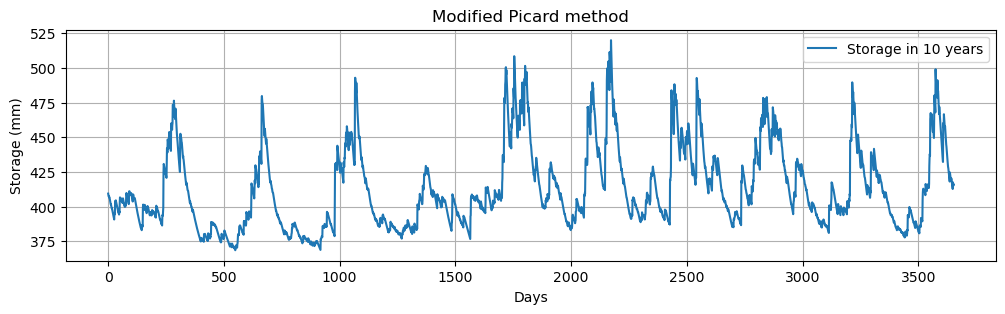

In [21]:
days=np.arange(len(qT))
storage=S*1000

plt.figure(figsize=(12, 3)) 
storage_plot = plt.plot(days, storage, label='Storage in 10 years') # Plot z vs psi for each dti
plt.xlabel('Days')
plt.ylabel('Storage (mm)')
plt.title('Modified Picard method')
plt.legend()  # Show legend with dti values
plt.grid(True)
plt.show()

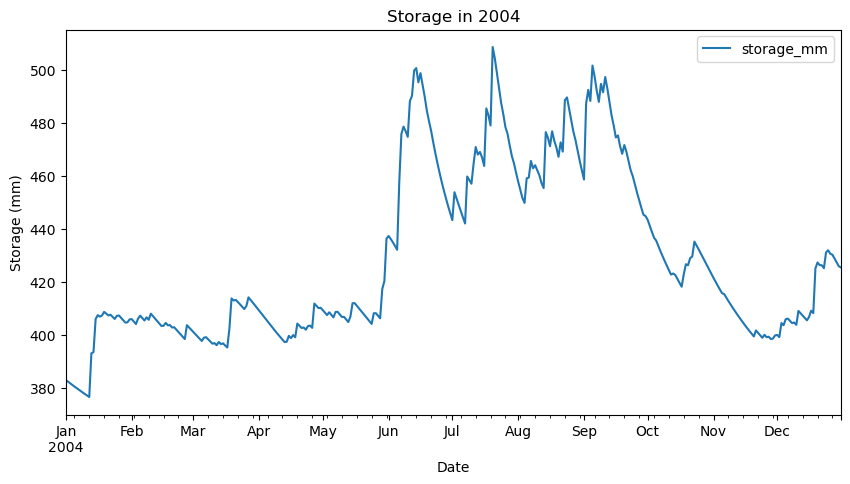

In [22]:
# Convert arrays to dataframes
days_df = pd.DataFrame({'days': days})
storage_df = pd.DataFrame({'storage_mm': storage})

# Concatenate dataframes along columns
vol_df = pd.concat([days_df, storage_df], axis=1)
# Starting date
start_date = '1999-10-01'  

# Create a range of dates starting from start_date, one for each row in the DataFrame
vol_df['date'] = pd.date_range(start=start_date, periods=len(vol_df), freq='D')
# Filtering the DataFrame for the year 2004
vol_df['date'] = pd.to_datetime(vol_df['date'])  # Ensure 'Date' is in datetime format
vol_2004 = vol_df[vol_df['date'].dt.year == 2004]

# Now plot
vol_2004.plot(x='date', y='storage_mm', title='Storage in 2004', figsize=(10, 5))
plt.xlabel('Date')  # Optional: Customize the x-axis label
plt.ylabel('Storage (mm)')  # Optional: Customize the y-axis label
plt.show()

# COMPARISON WITH HYDRUS

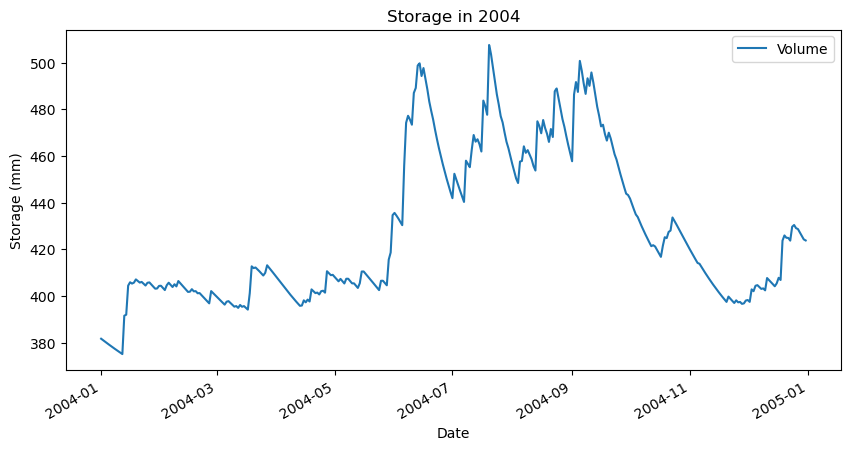

In [23]:
# Define the path to your data file
file_path = r"C:\Users\Luis\BENCHMARK TESTS\Flow boundary conditions\data\T_Level.out"

# Define column names based on the file's structure and content
column_names = ['Time', 'rTop', 'rRoot', 'vTop', 'vRoot', 'vBot', 'sum_rTop', 'sum_rRoot', 'sum_vTop', 'sum_vRoot', 'sum_vBot', 'hTop', 'hRoot', 'hBot', 'RunOff', 'sum_RunOff', 'Volume', 'sum_Infil', 'sum_Evap', 'TLevel', 'Cum_WTrans', 'SnowLayer']

# Read the CSV file, skipping the initial rows that don't contain data and setting the column names
data = pd.read_csv(file_path, delim_whitespace=True, skiprows=8, names=column_names)

# Convert necessary columns to numeric types, handling errors by coercing invalid values to NaN
numeric_columns = ['Time', 'rTop', 'rRoot', 'vTop', 'vRoot', 'vBot', 'sum_rTop', 'sum_rRoot', 'sum_vTop', 'sum_vRoot', 'sum_vBot', 'hTop', 'hRoot', 'hBot', 'RunOff', 'sum_RunOff', 'Volume', 'sum_Infil', 'sum_Evap', 'TLevel', 'Cum_WTrans', 'SnowLayer']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Assuming 'vTop' and 'vBot' are velocities and 'Volume' is a volume measurement
# Convert these to the desired units (as per your original code)
Qin = -data['vTop'] * 1000  # Multiply by 1000 to convert to desired units
Qout = -data['vBot'] * 1000
S = data['Volume'] * 1000

# Calculate the time steps
start_date = '1999-9-30'
data['t'] = pd.to_datetime(start_date) + pd.to_timedelta(data['Time'], unit='D')

# Create a new DataFrame for the processed data
processed_data = pd.DataFrame({
    'dt': np.hstack([0, np.diff(data['Time'].values)]),
    'Qin': Qin,
    'Qout': Qout,
    'S': S,
    'dS': np.hstack([0, np.diff(S)]),
    'cQ': np.cumsum((Qin - Qout) * np.hstack([0, np.diff(data['Time'].values)]))
}, index=data['t'])

# Filtering the DataFrame for the year 2004
data['t'] = pd.to_datetime(data['t'])  # Ensure 'Date' is in datetime format
hydrus_2004 = data[data['t'].dt.year == 2004]
hydrus_2004.loc[:, 'Volume'] = hydrus_2004['Volume'] * 1000

# Now plot
hydrus_2004.plot(x='t', y='Volume', title='Storage in 2004', figsize=(10, 5))
plt.xlabel('Date')  # Optional: Customize the x-axis label
plt.ylabel('Storage (mm)')  # Optional: Customize the y-axis label
plt.show()

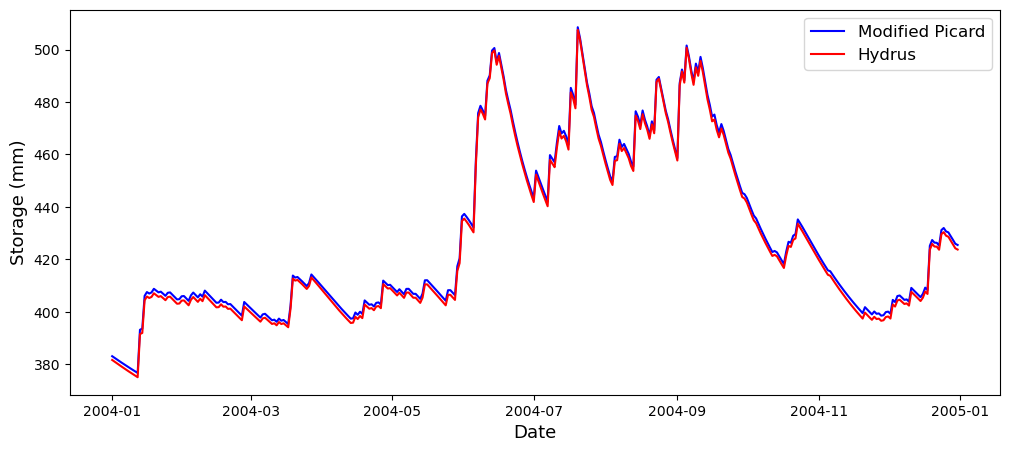

In [25]:
fig, ax1 = plt.subplots(figsize=(12, 5)) # create axes for plotting the reduces variate and increase the size of the plot

ax1.plot(vol_2004.date, vol_2004.storage_mm, "b-", label="Modified Picard") # plot our observed data
ax1.plot(hydrus_2004.t, hydrus_2004.Volume, "r-", label="Hydrus") # plot our fitted data for GEV distribution

ax1.set_xlabel("Date", fontsize=13) # label the axes
ax1.set_ylabel("Storage (mm)", fontsize=13)
ax1.legend(fontsize=12)

plt.show()